In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, explained_variance_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, MultiTaskLasso, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from sklearn.svm import SVR
import catboost 
import scipy.stats as st
import datetime
import re
import shap

In [2]:
shap.initjs()

## Функции

In [3]:
def clear_prof(x: str):
    x = x.lower()
    x = re.sub(r'\([^\)]+\)', '', x)
    x = x.strip()
    
    return x

In [4]:
def evaluate(predictions, test_features, test_labels):
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    adjR2 = 1 - (1-sklearn.metrics.r2_score(test_labels, predictions)) * LEN_PART
    print('Model Performance')
    print('Explanes Variance score: {:0.4f} '.format(explained_variance_score(test_labels, predictions)))
    print('Average Error: {:0.4f} days.'.format(np.mean(errors)))
    print('Accuracy MAPE = {:0.2f}%.'.format(mean_absolute_percentage_error(test_labels, predictions)))
    print('MAD = {}.'.format(np.sqrt(sklearn.metrics.median_absolute_error(test_labels, predictions))))
    print('MAE = {}.'.format(sklearn.metrics.mean_absolute_error(test_labels, predictions)))
    print('RMSE = {}.'.format(np.sqrt(sklearn.metrics.mean_squared_error(test_labels, predictions))))
    print('R2 = {}.'.format(sklearn.metrics.r2_score(test_labels, predictions)))
    print('Adj.R2 = {}.'.format(adjR2))
    
    return accuracy

## EDA

In [5]:
# Данные об заявках в работе и о данных внутри заявки 
podbor = pd.read_csv("../SVEL_Webapp_HR/data/А_Подбор__Заявка_на_подбор__20220525_10_17_49_AM.csv", header=6)
vacs = pd.read_csv("../SVEL_Webapp_HR/data/Открытые_вакансии_20220523_10_19_18_AM.csv", header=6)


#podbor = pd.read_excel("../SVEL_Webapp_HR/data/App_podbor.xlsx", header=7)
#vacs = pd.read_excel("../SVEL_Webapp_HR/data/Open_vacs.xlsx", header=7)

In [6]:
# Очистка названия столбцов от лишних слов
columns = []
for x in podbor.columns:
    x = x.replace("Заявка на поиск специалиста - Заявка на поиск специалиста: ", "")
    x = x.replace("Заявка на поиск специалиста - ", "")
    columns.append(x)
podbor.columns = columns 

In [7]:
podbor = podbor.loc[:,['Идентификатор заявки на поиск специалиста',
       'отображать название профессии',
       'тип занятости',
       'полная/частичная занятость', 'тип возмещения',
       'валютный диапазон — низкий', 'валютный диапазон — высокий',
       'тип валюты', 'Ежемесячный бонус (%)',
       'Причина открытия вакансии',
       'Количество подчиненных',
       'количество открытых вакансий (исходное)']]

In [8]:
vacs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Код вакансии                               1863 non-null   object
 1   Должность                                  1863 non-null   object
 2   Отдел                                      1863 non-null   object
 3   Функция                                    1835 non-null   object
 4   Местоположение                             1863 non-null   object
 5   Город                                      1827 non-null   object
 6   Страна                                     1862 non-null   object
 7   Статус заявки на поиск специалиста         1863 non-null   object
 8   Рекрутер                                   1768 non-null   object
 9   Количество вакансий (исходное)             1863 non-null   int64 
 10  Количество вакансий (текущее)       

In [9]:
vacs.drop_duplicates(subset="Код вакансии", keep="first")

,Код вакансии,Должность,Отдел,Функция,Местоположение,Город,Страна,Статус заявки на поиск специалиста,Рекрутер,Количество вакансий (исходное),...,HR,Начало подбора,Дата формирования заявки HR,Количество кандидатов в воронке,Дата поступления запроса на подбор,Общее количество кандидатов,Плановая дата закрытия,Срок подбора,Дата закрытия заявки на поиск специалиста,Приоритет закрытия
0,req10,Кладовщик-комплектовщик,(1200) Отдел закупок,NaN,пл.Первой пятилетки,Екатеринбург,RUS,Закрыто,NaN,1,...,"Калистратова-Гилева Мария,Широких Светлана",20.01.2020 17:07,16.01.2020 15:13,0,16.01.2020 9:20,0,19.01.2020 19:00,20,10.02.2020 16:38,High
1,req100,Оператор линии резки,(1020) Участок сборки магнитопровода и первой ...,Производство,пл.Первой пятилетки,Екатеринбург,RUS,Закрыто,"Ахмедова, Екатерина",1,...,"Калистратова-Гилева Мария,Широких Светлана",23.03.2020 14:32,03.03.2020 17:06,0,02.03.2020 18:03,1,29.03.2020 19:00,3,27.03.2020 13:21,High
2,req1000,Кладовщик-комплектовщик,(3010) Заготовительный участок №301,Производство,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Марков, Андрей",1,...,"Ткач Анастасия,Широких Светлана",08.06.2021 14:26,07.06.2021 10:02,0,03.06.2021 11:41,200,23.09.2021 0:00,225,20.01.2022 9:43,High
3,req1001,Бизнес-методолог,(0910) Отдел организационного развития,IT,Черняховского 61,Екатеринбург,RUS,Отменено,"Борзенко, Елена",1,...,"Телегин Алексей,Чечетина Наталия,Широких Светлана",08.06.2021 14:23,07.06.2021 10:15,0,07.06.2021 9:56,23,07.09.2021 0:00,269,NaN,Medium
4,req1002,Оператор намоточного станка ВН,(1010) Обмоточно-заливочный участок,Производство,пл.Первой пятилетки,Екатеринбург,RUS,Закрыто,"Юдина, Алия",1,...,"Калистратова-Гилева Мария,Широких Светлана",08.06.2021 14:24,07.06.2021 12:19,0,07.06.2021 10:46,6,16.07.2021 0:00,20,28.06.2021 23:30,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858,req995,Инженер-конструктор,(1620) Конструкторский отдел Реакторов,Инженерные службы,пл.Первой пятилетки,Екатеринбург,RUS,Закрыто,"Ахмедова, Екатерина",1,...,"Калистратова-Гилева Мария,Широких Светлана",07.06.2021 9:33,04.06.2021 17:38,0,04.06.2021 17:10,3,30.09.2021 0:00,57,03.08.2021 11:23,High
1859,req996,Бизнес-аналитик финансовых систем,(0500) Финансовая служба,Финансовый отдел,Черняховского 61,Екатеринбург,RUS,ОТКРЫТЬ,"Горбунова, Наталья",1,...,"Новосельцева Татьяна,Широких Светлана",11.06.2021 17:39,05.06.2021 21:34,0,04.06.2021 16:34,82,11.10.2021 0:00,347,NaN,High
1860,req997,Менеджер по управлению рисками,(0500) Финансовая служба,Финансовый отдел,Черняховского 61,Екатеринбург,RUS,Закрыто,"Борзенко, Елена",1,...,"Домнина Вероника,Чечетина Наталия,Широких Свет...",11.06.2021 17:40,05.06.2021 21:38,0,04.06.2021 16:15,42,08.10.2021 0:00,149,08.11.2021 9:48,High
1861,req998,Программист,(0410) Отдел практики и стажировки (АО Группа),IT,пл.Первой пятилетки,Екатеринбург,RUS,Закрыто,"Горбунова, Наталья",1,...,"Чечетина Наталия,Широких Светлана",16.06.2021 14:52,05.06.2021 21:49,0,03.06.2021 17:51,22,14.09.2021 0:00,60,16.08.2021 9:20,High


In [10]:
podbor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6760 entries, 0 to 6759
Data columns (total 12 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Идентификатор заявки на поиск специалиста  6760 non-null   object 
 1   отображать название профессии              6760 non-null   object 
 2   тип занятости                              6760 non-null   object 
 3   полная/частичная занятость                 6760 non-null   object 
 4   тип возмещения                             6760 non-null   object 
 5   валютный диапазон — низкий                 6760 non-null   object 
 6   валютный диапазон — высокий                6760 non-null   object 
 7   тип валюты                                 6760 non-null   object 
 8   Ежемесячный бонус (%)                      6324 non-null   float64
 9   Причина открытия вакансии                  6760 non-null   object 
 10  Количество подчиненных  

In [11]:
#Удаление дупликатов из датафрейма. Строки пвторяются за исключением того, что меняется Рецензент заявки на поиск специалиста — полное имя
podbor = podbor.sort_values( by='Идентификатор заявки на поиск специалиста')
podbor = podbor.drop_duplicates(subset="Идентификатор заявки на поиск специалиста", keep="first")

In [12]:
#Собираем все в один Датафрейм
df = pd.merge(vacs, podbor, how='left', left_on='Код вакансии', right_on='Идентификатор заявки на поиск специалиста')

In [13]:
df.describe()

,Количество вакансий (исходное),Количество вакансий (текущее),Количество кандидатов в воронке,Общее количество кандидатов,Срок подбора,Ежемесячный бонус (%),Количество подчиненных,количество открытых вакансий (исходное)
count,1863.000000,1863.000000,1863.000000,1863.000000,1863.000000,1657.000000,615.000000,1863.000000
mean,1.319377,0.447128,0.937735,29.306495,91.697262,66.059143,5.645528,1.319377
std,1.372386,1.003897,3.110805,60.820129,96.547822,736.314450,30.994502,1.372386
min,0.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,23.000000,30.000000,0.000000,1.000000
50%,1.000000,0.000000,0.000000,11.000000,62.000000,30.000000,0.000000,1.000000
75%,1.000000,1.000000,0.000000,33.000000,126.000000,65.000000,0.000000,1.000000
max,32.000000,23.000000,38.000000,914.000000,719.000000,30000.000000,500.000000,32.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 1862
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Код вакансии                               1863 non-null   object 
 1   Должность                                  1863 non-null   object 
 2   Отдел                                      1863 non-null   object 
 3   Функция                                    1835 non-null   object 
 4   Местоположение                             1863 non-null   object 
 5   Город                                      1827 non-null   object 
 6   Страна                                     1862 non-null   object 
 7   Статус заявки на поиск специалиста         1863 non-null   object 
 8   Рекрутер                                   1768 non-null   object 
 9   Количество вакансий (исходное)             1863 non-null   int64  
 10  Количество вакансий (тек

In [15]:
df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', 'Срок подбора'].median()

62.0

In [16]:
df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', 'Срок подбора'].mean()

87.30601092896175

[Text(0.5, 0, 'Срок подбора'), Text(0, 0.5, 'Количество')]

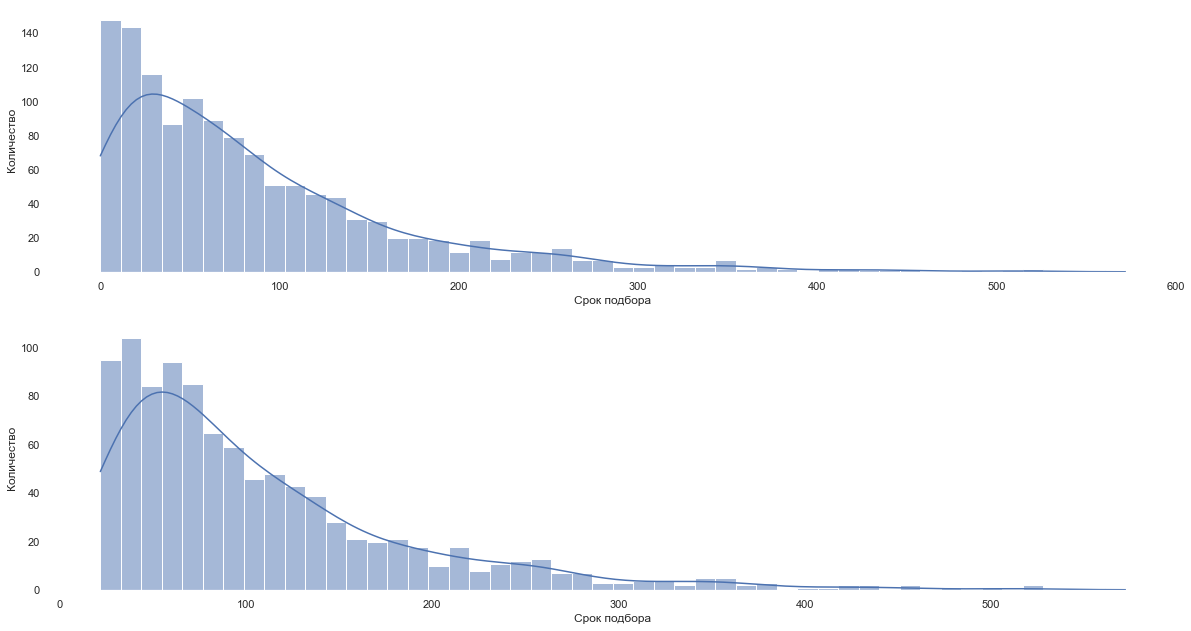

In [17]:
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig, axes = plt.subplots(2, 1, figsize=(18, 10))


sns.histplot(df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', 'Срок подбора'], kde=True, bins=50, ax=axes[0])
sns.histplot(df.loc[(df['Статус заявки на поиск специалиста'] == 'Закрыто') & (df['Срок подбора'] > 21), 'Срок подбора'], kde=True, bins=50, ax=axes[1])

axes[0].set(xlabel='Срок подбора', ylabel='Количество')
axes[1].set(xlabel='Срок подбора', ylabel='Количество')

In [18]:
df.loc[(df['Статус заявки на поиск специалиста'] == 'Закрыто') & (df['Срок подбора'] > 300), :'Начало подбора']

,Код вакансии,Должность,Отдел,Функция,Местоположение,Город,Страна,Статус заявки на поиск специалиста,Рекрутер,Количество вакансий (исходное),Количество вакансий (текущее),HR,Начало подбора
144,req113,Технолог по складкой логистике,(0200) Департамент закупок и логистики,Закупка и логистика,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Горбунова, Наталья",1,0,"Чечетина Наталия,Широких Светлана",11.03.2020 15:43
263,req124,Личный помощник руководителя,(0000) Дирекция,Секретариат,Черняховского 61,Екатеринбург,RUS,Закрыто,"Горбунова, Наталья",1,0,"Чечетина Наталия,Широких Светлана",16.03.2020 18:18
407,req137,Инженер-конструктор,(5660) Конструкторский отдел РУБМ,Инженерные службы,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Ахмедова, Екатерина",1,0,"Корольков Дмитрий,Широких Светлана",26.03.2020 16:31
883,req18,Методолог по бухгалтерскому и налоговому учету,(0400) Служба управления персоналом,Финансовый отдел,Черняховского 61,Екатеринбург,RUS,Закрыто,"Горбунова, Наталья",1,0,"Чечетина Наталия,Широких Светлана",07.02.2020 13:56
989,req195,Руководитель отдела закупок (HHI),Отдел закупок (Hyundai),Закупка и логистика,Rojen 41,Sofia,BGR,Закрыто,"Щракова, Северина",1,0,Гоцич Елена,07.05.2020 11:02
1014,req218,Section Chief TR (Hyundai),Отдел закупок (Hyundai),Закупка и логистика,Rojen 41,Sofia,BGR,Закрыто,"Щракова, Северина",1,0,"Гоцич Елена,Кишко Оксана,Матвеев Сергей",04.06.2020 13:46
1031,req233,Слесарь по сборке металлоконструкций,(3050) Сборо-сварочный участок №305,Производство,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Юдина, Алия",1,0,"Ткач Анастасия,Широких Светлана",22.05.2020 8:45
1032,req234,Слесарь по сборке металлоконструкций,(3050) Сборо-сварочный участок №305,Производство,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Юдина, Алия",1,0,"Ткач Анастасия,Широких Светлана",22.05.2020 8:45
1088,req285,Оператор станков с программным управлением,(3010) Заготовительный участок №301,Производство,Альпинистов 57,Екатеринбург,RUS,Закрыто,"Юдина, Алия",1,0,"Ткач Анастасия,Широких Светлана",16.06.2020 15:47
1114,req309,Менеджер по продажам,Отдел продаж Польша (BEZ),Продажи,Rybničná 40,Bratislava,SVK,Закрыто,"Frtúsová, Lucia",3,1,Frtúsová Lucia,30.06.2020 9:54


<AxesSubplot:xlabel='Количество вакансий (исходное)', ylabel='Count'>

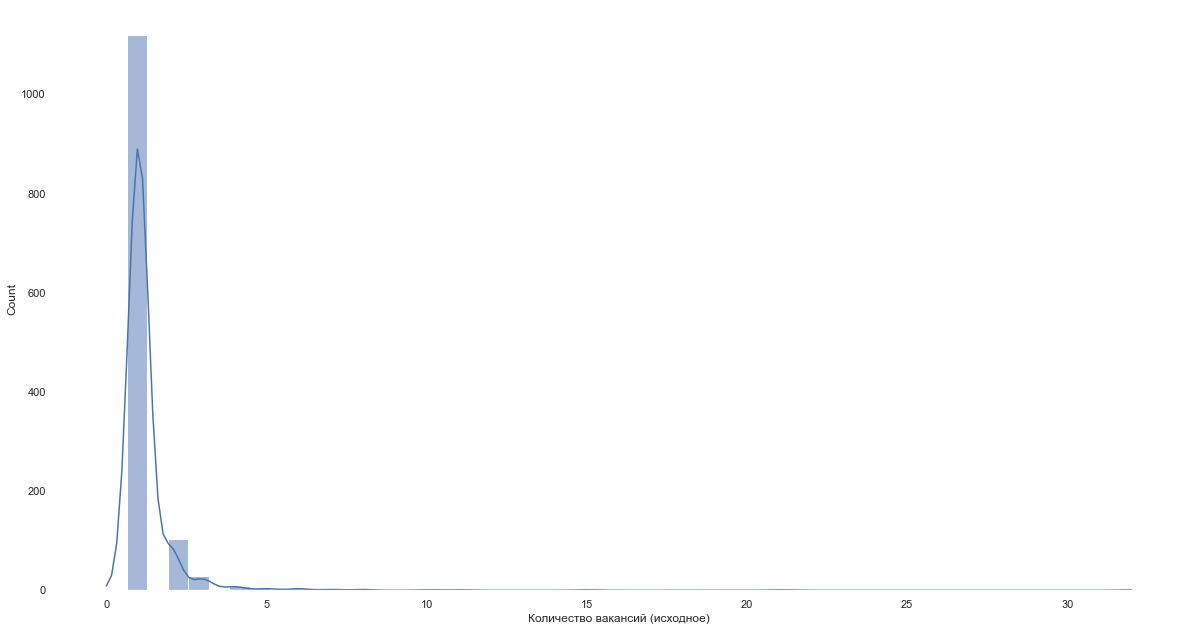

In [24]:
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, axes = plt.subplots(figsize=(18, 10))

sns.histplot(df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', 'Количество вакансий (исходное)'], kde=True, bins=50)


In [25]:
df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', ['Код вакансии', 'Количество вакансий (исходное)']].groupby('Количество вакансий (исходное)').count()

,Код вакансии
Количество вакансий (исходное),
0,3
1,1120
2,104
3,28
4,9
5,4
6,4
7,2
8,2


<AxesSubplot:xlabel='Количество вакансий (исходное)', ylabel='count'>

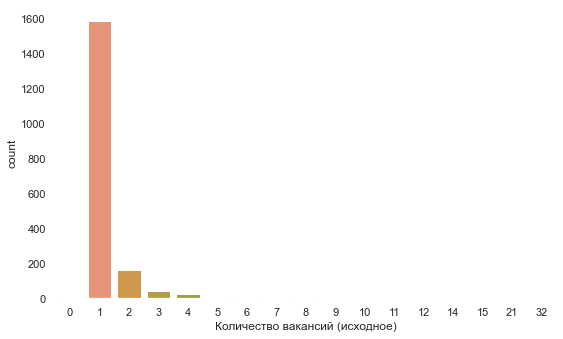

In [26]:
plt.figure(figsize=(8,5))
sns.countplot(x='Количество вакансий (исходное)', data=df)

In [27]:
len(df['Функция'].unique())

14

In [28]:
df['Плановая дата закрытия'] = pd.to_datetime(df['Плановая дата закрытия'], format='%d.%m.%Y %H:%M')
df['Начало подбора'] = pd.to_datetime(df['Начало подбора'], format='%d.%m.%Y %H:%M')
df['Дата поступления запроса на подбор'] = pd.to_datetime(df['Дата поступления запроса на подбор'], format='%d.%m.%Y %H:%M')
df['Дата формирования заявки HR'] = pd.to_datetime(df['Дата формирования заявки HR'], format='%d.%m.%Y %H:%M')
df['Дата закрытия заявки на поиск специалиста'] = pd.to_datetime(df['Дата закрытия заявки на поиск специалиста'], format='%d.%m.%Y %H:%M')

In [29]:
df['Срок от формирования до начала подбора'] = (df['Начало подбора'] - df['Дата формирования заявки HR']).dt.days
df['Срок от поступления до начала подбора'] = (df['Начало подбора'] - df['Дата поступления запроса на подбор']).dt.days
df['Плановый срок подбора'] = (df['Плановая дата закрытия'] - df['Начало подбора']).dt.days
df['Просрок'] = (df['Плановая дата закрытия'] - df['Дата закрытия заявки на поиск специалиста']).dt.days

In [30]:
df['валютный диапазон — низкий'] = df['валютный диапазон — низкий'].str.replace(',', '').astype(int)
df['валютный диапазон — высокий'] = df['валютный диапазон — высокий'].str.replace(',', '').astype(int)

<AxesSubplot:>

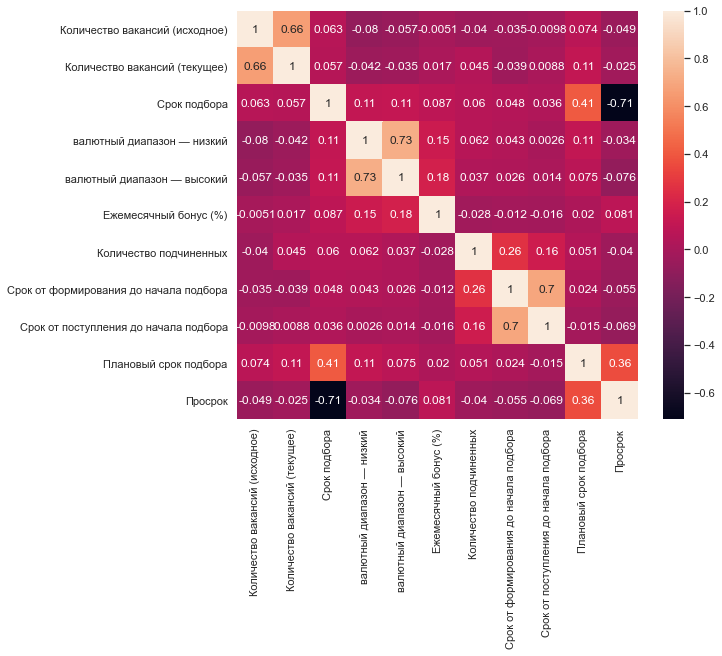

In [31]:
plt.figure(figsize=(8,7))
sns.heatmap(df.loc[:, ['Количество вакансий (исходное)', 'Количество вакансий (текущее)',
                       'Срок подбора','валютный диапазон — низкий', 'валютный диапазон — высокий',
                       'Ежемесячный бонус (%)', 'Количество подчиненных',
                      'Срок от формирования до начала подбора', 
                      'Срок от поступления до начала подбора', 'Плановый срок подбора', 'Просрок']].corr(), annot=True)

[Text(0.5, 0, 'Просрок'), Text(0, 0.5, 'Количество')]

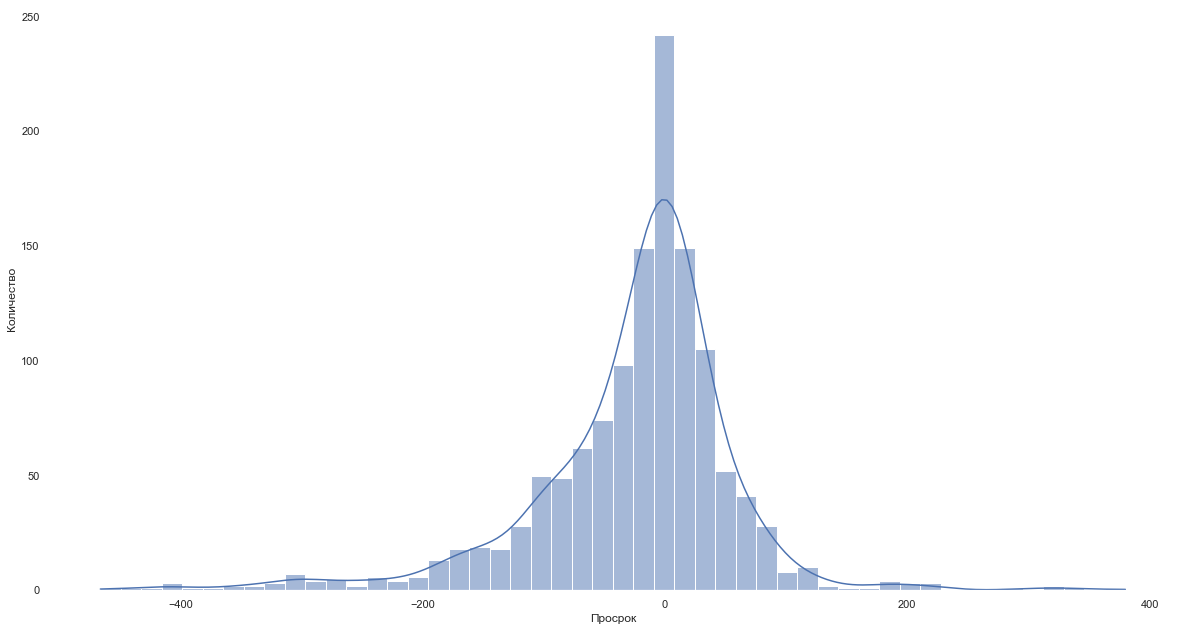

In [32]:
plt.style.use('fivethirtyeight')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
fig, axes = plt.subplots(figsize=(18, 10))

ax = sns.histplot(df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', 'Просрок'], kde=True, bins=50)
ax.set(xlabel='Просрок', ylabel='Количество')

In [33]:
df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', ['Просрок']].describe()

,Просрок
count,1281.000000
mean,-25.288056
std,84.609077
min,-466.000000
25%,-57.000000
50%,-9.000000
75%,17.000000
max,380.000000


In [34]:
df.loc[:,['тип занятости', 'Код вакансии']].groupby(['тип занятости']).count().sort_values(['Код вакансии'],ascending=False)

,Код вакансии
тип занятости,
Бессрочный договор,1632
Срочный договор,207
Стажер,17
Договор подряда,7


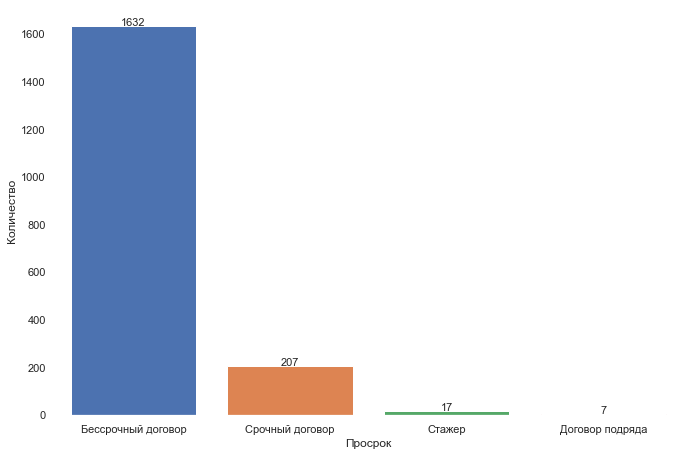

In [35]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x='тип занятости', data=df, saturation=2)
ax.set(xlabel='Просрок', ylabel='Количество')

for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()  / 2, rect.get_height()+ 0.95,rect.get_height(),horizontalalignment='center', fontsize = 11)

In [36]:
df.loc[:,['Страна', 'Код вакансии']].groupby(['Страна']).count().sort_values(['Код вакансии'],ascending=False)

,Код вакансии
Страна,
RUS,1451
BGR,193
SVK,141
CZE,68
UZB,3
KAZ,2
AZE,1
BLR,1
LVA,1


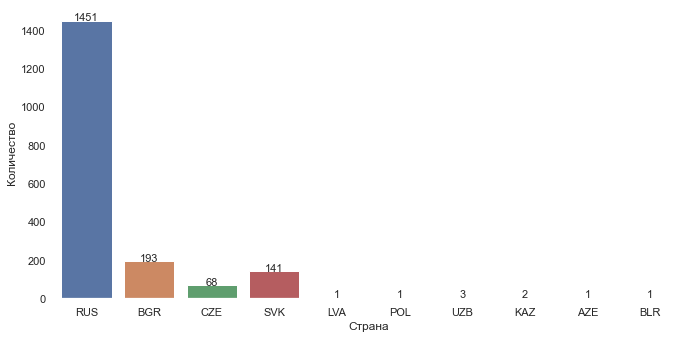

In [37]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='Страна', data=df)
ax.set(xlabel='Страна', ylabel='Количество')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()  / 2, rect.get_height()+ 0.95,rect.get_height(),horizontalalignment='center', fontsize = 11)

In [38]:
df.loc[:,['полная/частичная занятость', 'Код вакансии']].groupby(['полная/частичная занятость']).count().sort_values(['Код вакансии'],ascending=False)

,Код вакансии
полная/частичная занятость,
Full Time,1849
Part Time,14


In [39]:
df.loc[:,['Причина открытия вакансии', 'Код вакансии']].groupby(['Причина открытия вакансии']).count().sort_values(['Код вакансии'],ascending=False)

,Код вакансии
Причина открытия вакансии,
Увольнение,1024
Новая вакансия,497
Внутренний перевод,207
Длительное отсутствие,85
Временная работа,50


In [40]:
df.loc[df['Причина открытия вакансии'] == 'Внутренний перевод', ['Срок подбора']].describe()

,Срок подбора
count,207.000000
mean,86.512077
std,99.667645
min,0.000000
25%,18.000000
50%,54.000000
75%,120.500000
max,572.000000


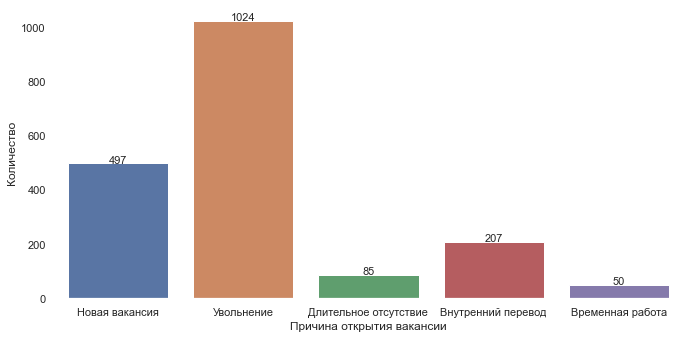

In [41]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x='Причина открытия вакансии', data=df)

ax.set(xlabel='Причина открытия вакансии', ylabel='Количество')
for rect in ax.patches:
    ax.text(rect.get_x() + rect.get_width()  / 2, rect.get_height()+ 0.95,rect.get_height(),horizontalalignment='center', fontsize = 11)

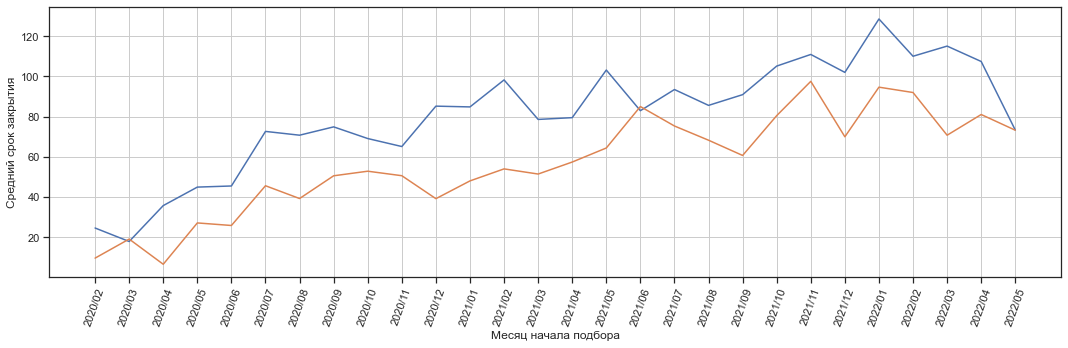

In [42]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})
df['МесяцГод закрытия'] = df['Дата закрытия заявки на поиск специалиста'].dt.strftime('%Y/%m')
group = df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', ['МесяцГод закрытия', 'Срок подбора', 'Плановый срок подбора']].groupby(['МесяцГод закрытия']).mean().reset_index()
ax=sns.lineplot(data=group, x="МесяцГод закрытия", y="Срок подбора")
ax=sns.lineplot(data=group, x="МесяцГод закрытия", y="Плановый срок подбора")
ax.set(xlabel='Месяц начала подбора', ylabel='Средний срок закрытия')
plt.xticks(rotation=70)
plt.tight_layout()

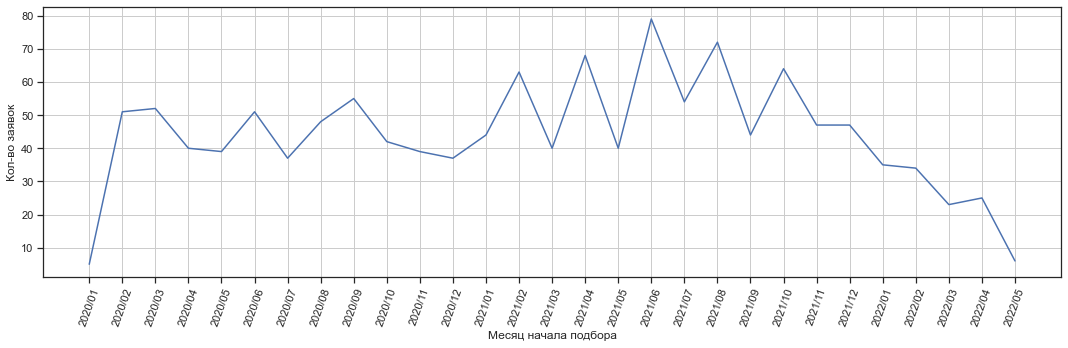

In [43]:
plt.figure(figsize=(15,5))
sns.set_style("ticks",{'axes.grid' : True})
df['МесяцГод начало подбора'] = df['Начало подбора'].dt.strftime('%Y/%m')
group = df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', ['МесяцГод начало подбора', 'Срок подбора']].groupby(['МесяцГод начало подбора']).count().reset_index()
ax = sns.lineplot(data=group, x="МесяцГод начало подбора", y="Срок подбора")
ax.set(xlabel='Месяц начала подбора', ylabel='Кол-во заявок')
plt.xticks(rotation=70)
plt.tight_layout()

In [45]:
df.loc[df['Статус заявки на поиск специалиста'] == 'Закрыто', ['МесяцГод начало подбора', 'Срок подбора']].groupby(['МесяцГод начало подбора']).count().reset_index()['Срок подбора'].mean()

44.172413793103445

## Preprocessing

In [40]:
df['Должность'] = df['Должность'].apply(clear_prof)

In [41]:
#Из-за малого количества Стажер и Договор подряда преобразуем их в Срочный договор
df.loc[(df['тип занятости'] == 'Договор подряда') | (df['тип занятости'] == 'Стажер'), 'тип занятости'] = 'Срочный договор'
# Оставляем только СНГ
df = df.loc[(df['Страна'] == "RUS"), :]

In [42]:
#Преобразование категориальных переменых в бинарные 

df.loc[df['тип занятости'] == 'Бессрочный договор', 'тип занятости'] = 0
df.loc[df['тип занятости'] == 'Срочный договор', 'тип занятости'] = 1
df['тип занятости']  = df['тип занятости'].astype(int)

df.loc[df['полная/частичная занятость'] == 'Part Time', 'полная/частичная занятость'] = 0
df.loc[df['полная/частичная занятость'] == 'Full Time', 'полная/частичная занятость'] = 1
df['полная/частичная занятость'] = df['полная/частичная занятость'].astype(int)

df.loc[df['тип возмещения'] == 'Почасовая заработная плата', 'тип возмещения'] = 0
df.loc[df['тип возмещения'] == 'Месячная заработная плата', 'тип возмещения'] = 1
df['тип возмещения']  = df['тип возмещения'].astype(int)

2022-06-02 21:20:40,287 [16576] WARNING  py.warnings:109: [JupyterRequire] 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2022-06-02 21:20:40,297 [16576] WARNING  py.warnings:109: [JupyterRequire] 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

2022-06-02 21:20:40,305 [16576] WARNING  py.warnings:109: [JupyterRequire] 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [43]:
df = df.sort_values(['Дата формирования заявки HR'])

In [44]:

df['Обработано заявок'] = 0
recrs = df['Рекрутер'].unique()
for r in recrs:
    dates = df.loc[(df['Рекрутер'] == r) & 
                    (df['Статус заявки на поиск специалиста'] == 'Закрыто'), 'Дата формирования заявки HR'].dt.date.unique()
    for date in dates:
        b = df.loc[(df['Рекрутер'] == r) & 
                (df['Дата формирования заявки HR'].dt.date < date) & 
                (df['Статус заявки на поиск специалиста'] == 'Закрыто'), :] 
        df.loc[(df['Рекрутер'] == r) & (df['Дата формирования заявки HR'].dt.date == date), 'Обработано заявок'] = len(b)

In [45]:
df = df.sort_values(['Начало подбора'])

In [46]:
df['Обработано вакансий за месяц по отделу'] = 0
deps = df['Отдел'].unique()
for d in deps:
    dates = df.loc[(df['Отдел'] == d) & 
                (df['Статус заявки на поиск специалиста'] == 'Закрыто'), 'Начало подбора'].dt.date.unique()
    for date in dates:
        date1 = datetime.date(date.year, date.month, 1)
        n_vac = df.loc[  (df['Отдел'] == d) & 
                        (df['Начало подбора'].dt.date <= date) & 
                        (df['Начало подбора'].dt.date >= date1) & 
                        (df['Статус заявки на поиск специалиста'] == 'Закрыто'), 'Количество вакансий (исходное)'].sum() 
        df.loc[  (df['Отдел'] == d) & 
                (df['Начало подбора'].dt.date <= date) & 
                  (df['Начало подбора'].dt.date >= date1), 'Обработано вакансий за месяц по отделу'] = n_vac

In [47]:
df['Обработано вакансий за месяц по должности'] = 0
occup = df['Должность'].unique()
for o in occup:
    dates = df.loc[(df['Должность'] == o) & 
                (df['Статус заявки на поиск специалиста'] == 'Закрыто'), 'Начало подбора'].dt.date.unique()
    for date in dates:
        date1 = datetime.date(date.year, date.month, 1)
        n_vac = df.loc[(df['Должность'] == o) & 
                    (df['Начало подбора'].dt.date <= date) & 
                    (df['Начало подбора'].dt.date >= date1) & 
                    (df['Статус заявки на поиск специалиста'] == 'Закрыто'), 'Количество вакансий (исходное)'].sum() 
        df.loc[(df['Должность'] == o) & 
            (df['Начало подбора'].dt.date <= date) & 
            (df['Начало подбора'].dt.date >= date1), 'Обработано вакансий за месяц по должности'] = n_vac

In [48]:
df['Месяц начала подбора'] = df['Начало подбора'].dt.month
df['Месяц формирования заявки HR'] = df['Дата формирования заявки HR'].dt.month

<AxesSubplot:>

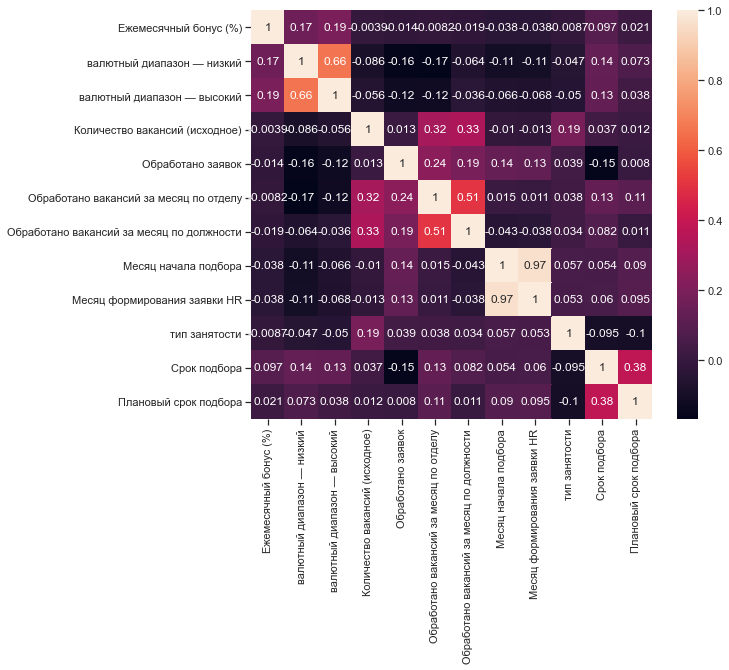

In [49]:
plt.figure(figsize=(8,7))
sns.heatmap(df.loc[:, ['Ежемесячный бонус (%)', 
                    'валютный диапазон — низкий', 
                    'валютный диапазон — высокий', 
                    'Количество вакансий (исходное)',
                    'Обработано заявок', 
                    'Обработано вакансий за месяц по отделу', 
                    'Обработано вакансий за месяц по должности',
                    'Месяц начала подбора',
                    'Месяц формирования заявки HR',
                    'Отдел',
                    'Рекрутер',
                    'тип занятости',
                      'Срок подбора', 
                      'Плановый срок подбора']].corr(), annot=True)

## ML

In [50]:
buf = df.copy()
buf = buf.loc[buf['Статус заявки на поиск специалиста'] == 'Закрыто', :]
buf = buf.loc[(buf['Начало подбора'].dt.date > datetime.date(2020, 7, 1)), :] # & (buf['Срок подбора'] > 21)
buf = buf.loc[ (buf['Общее количество кандидатов'] > 0), :]
buf.loc[(buf['Срок подбора'] < 1), 'Срок подбора'] = 1

In [54]:
pred_columns = ['Ежемесячный бонус (%)', 
                    'валютный диапазон — низкий', 
                    'валютный диапазон — высокий', 
                    'Количество вакансий (исходное)',
                    'Обработано заявок', 
                    'Обработано вакансий за месяц по отделу', 
                    'Обработано вакансий за месяц по должности',
                    'Месяц начала подбора',
                    #'тип возмещения',
                    'полная/частичная занятость',
                    'Месяц формирования заявки HR',
                    'Отдел',
                    'Рекрутер',
                    #'Функция'
               ]
#                    'ЛИД вакансии',]

In [55]:
X = buf.loc[:, pred_columns]
y = buf.loc[:, 'Срок подбора']

#X.loc[:, ['Функция']] = X.loc[:, ['Функция']].fillna("Нет")
X.loc[:, ['Отдел']] = X.loc[:, ['Отдел']].fillna("Нет")
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=728)

Xcolumns = X_train.columns


train, test, train2, test2 = train_test_split(buf, buf['Срок подбора'], test_size=0.2, random_state=728)


In [56]:
print(len(X_train))
print(len(X_test))

665
167


In [57]:
cat_features = [10, 11]

LEN_PART = (len(y)-1)/(len(y)-X.shape[1]-1)

cat = catboost.CatBoostRegressor(iterations = 1000, cat_features = cat_features) #, logging_level='Silent')
cat.fit(X_train, y_train , verbose=100, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [58]:
y_predict = cat.predict(X_test)

In [59]:
evaluate(y_predict, X_test, y_test)

Model Performance
Explanes Variance score: 0.3111 
Average Error: 54.6268 days.
Accuracy MAPE = 3.87%.
MAD = 6.5355672500876.
MAE = 54.62680160522823.
RMSE = 76.46841379447544.
R2 = 0.3049018566887033.
Adj.R2 = 0.29471726850831803.


-287.0888551144625

In [156]:
evaluate(cat.predict(X_train), X_train, y_train)

Model Performance
Explanes Variance score: 0.7336 
Average Error: 30.4311 days.
Accuracy MAPE = 1.49%.
MAD = 4.813303810678707.
MAE = 30.431111391576017.
RMSE = 41.607787932523536.
R2 = 0.7331090206725389.
Adj.R2 = 0.7291985301329424.


-48.82305255745979

In [148]:
evaluate(test['Плановый срок подбора'], test, test['Срок подбора'])

Model Performance
Explanes Variance score: -0.0665 
Average Error: 61.0838 days.
Accuracy MAPE = 2.76%.
MAD = 5.744562646538029.
MAE = 61.08383233532934.
RMSE = 96.82260462550606.
R2 = -0.11438559123437342.
Adj.R2 = -0.1320958756916435.


-176.32638711056126

In [169]:
pd.DataFrame(y_predict - y_test).describe()

,Срок подбора
count,167.000000
mean,-7.246366
std,76.353242
min,-342.379626
25%,-43.280557
50%,3.921542
75%,40.523768
max,180.120969


In [171]:
pd.DataFrame(test['Плановый срок подбора'] - test['Срок подбора']).describe()

,0
count,167.000000
mean,-20.065868
std,95.005399
min,-421.000000
25%,-48.500000
50%,-7.000000
75%,24.500000
max,317.000000


In [157]:
pd.DataFrame({'name':X.columns,'imp': list(cat.feature_importances_)}).sort_values('imp', ascending=False)

,name,imp
4,Обработано заявок,23.556444
11,Рекрутер,15.394158
10,Отдел,13.467658
2,валютный диапазон — высокий,13.216244
1,валютный диапазон — низкий,8.706234
5,Обработано вакансий за месяц по отделу,5.817252
0,Ежемесячный бонус (%),5.345957
6,Обработано вакансий за месяц по должности,5.012969
7,Месяц начала подбора,4.796085
9,Месяц формирования заявки HR,3.388713


In [62]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [63]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

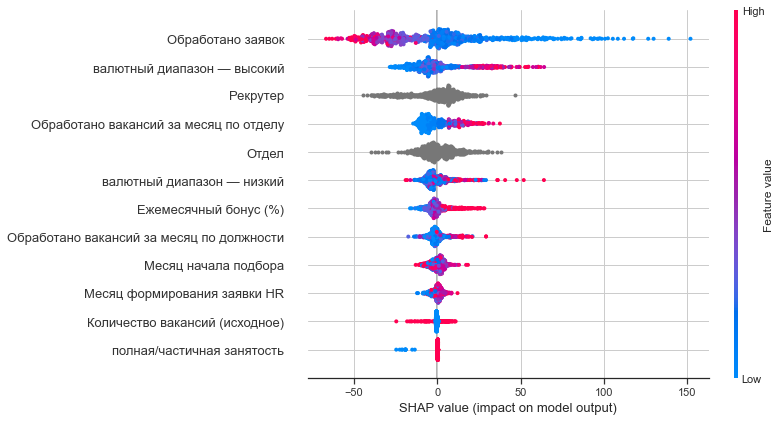

In [167]:
shap.summary_plot(shap_values, X)

In [168]:
df.to_excel('test_df.xlsx')

,Ежемесячный бонус (%),валютный диапазон — низкий,валютный диапазон — высокий,Количество вакансий (исходное),Обработано заявок,Обработано вакансий за месяц по отделу,Обработано вакансий за месяц по должности,Месяц начала подбора,полная/частичная занятость,Месяц формирования заявки HR,...,"Рекрутер_Нигматуллина, Анастасия","Рекрутер_Ниязова, Анна","Рекрутер_Подзорова, Александра","Рекрутер_Рахманова, Анна","Рекрутер_Смолякова, Ирина","Рекрутер_Сусол, Кира","Рекрутер_Ткач, Анастасия","Рекрутер_Чернышова, Злата","Рекрутер_Шатерникова, Юлия","Рекрутер_Юдина, Алия"
1132,50.0,1700000,1700000,1,6,1,1,7.0,1,7,...,0,0,0,0,0,0,0,0,0,0
1133,100.0,1500000,2400000,1,56,5,1,7.0,1,7,...,0,1,0,0,0,0,0,0,0,0
1136,70.0,2300000,3000000,1,33,5,1,7.0,1,7,...,0,0,0,0,0,0,0,0,0,0
1138,40.0,1890000,2900000,1,7,1,1,7.0,1,7,...,0,0,0,0,0,0,0,0,0,0
1075,65.0,2430000,2910000,1,46,1,1,7.0,1,6,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,50.0,2000000,2000000,1,2,2,2,4.0,1,4,...,0,0,0,0,0,0,0,0,0,0
932,50.0,2200000,2500000,1,77,1,1,5.0,1,4,...,0,0,0,0,0,0,0,0,0,0
941,40.0,1890000,3200000,1,4,1,1,5.0,1,5,...,0,0,1,0,0,0,0,0,0,0
962,30.0,4200000,5600000,1,29,2,2,5.0,1,5,...,0,0,0,0,0,0,0,0,0,0


In [68]:
X = buf.loc[:, pred_columns]
y = buf.loc[:, 'Срок подбора']

#X.loc[:, ['Функция']] = X.loc[:, ['Функция']].fillna("Нет")
X.loc[:, ['Отдел']] = X.loc[:, ['Отдел']].fillna("Нет")
X = X.fillna(0)

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=728)

Xcolumns = X_train.columns

In [69]:
rfr = RandomForestRegressor(n_estimators=150, max_features='log2',min_impurity_decrease=0.08)
rfr.fit(X_train, y_train)
evaluate(rfr.predict(X_test), X_test, y_test)

Model Performance
Explanes Variance score: 0.2657 
Average Error: 56.9259 days.
Accuracy MAPE = 3.80%.
MAD = 6.3168865399483005.
MAE = 56.925905012483085.
RMSE = 78.99822858525098.
R2 = 0.2581490258787359.
Adj.R2 = 0.24727941453629987.


-280.08471024215885

In [71]:
evaluate(rfr.predict(X_train), X_train, y_train)

Model Performance
Explanes Variance score: 0.8422 
Average Error: 23.6426 days.
Accuracy MAPE = 1.40%.
MAD = 4.275546720735097.
MAE = 23.64257351083099.
RMSE = 31.994941226141627.
R2 = 0.8421853653606673.
Adj.R2 = 0.8398730630216296.


-39.889452816515956

In [74]:
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(lr.predict(X_test), X_test, y_test)
evaluate(lr.predict(X_train), X_train, y_train)

Model Performance
Explanes Variance score: -41919062.0286 
Average Error: 93089.7671 days.
Accuracy MAPE = 4768.04%.
MAD = 7.149919389119431.
MAE = 93089.76713839517.
RMSE = 601077.0661973396.
R2 = -42947933.41721887.
Adj.R2 = -43577207.181573726.
Model Performance
Explanes Variance score: 0.3887 
Average Error: 46.1855 days.
Accuracy MAPE = 2.49%.
MAD = 6.078175044405343.
MAE = 46.18551859536341.
RMSE = 62.96825420086252.
R2 = 0.3887372287691.
Adj.R2 = 0.3797809976887938.


-149.35711162282144

In [78]:
knn = KNeighborsRegressor()

knn.fit(X_train, y_train)
evaluate(knn.predict(X_test), X_test, y_test)
evaluate(knn.predict(X_train), X_train, y_train)

Model Performance
Explanes Variance score: 0.0743 
Average Error: 61.7521 days.
Accuracy MAPE = 4.27%.
MAD = 6.782329983125268.
MAE = 61.75209580838324.
RMSE = 88.29813270687528.
R2 = 0.07320217897426784.
Adj.R2 = 0.05962272372114363.
Model Performance
Explanes Variance score: 0.3728 
Average Error: 45.8968 days.
Accuracy MAPE = 2.41%.
MAD = 5.621387729022078.
MAE = 45.89684210526316.
RMSE = 63.78527277167035.
R2 = 0.3727719457581731.
Adj.R2 = 0.3635817911172672.


-141.35129833710033